## Modules à importer

In [ ]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from snprop import survey
from variaIa import baserate
from importlib import reload
from variaIa import stretchevol
from scipy.stats import poisson
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

### Définition des données à montrer

In [ ]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')
btw = ipw.Checkbox(
    value=False,
    description='btw')
after = ipw.Checkbox(
    value=False,
    description='After')

In [5]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

raw_df_snf = d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]
surv = {'SNF':  raw_df_snf[raw_df_snf['salt2.Color'] < 0.3],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)
z_max['HST'] = [10, 10]

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()
M_zcuts = dict()

z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values
c_zcuts['SNF'] = surv['SNF']['salt2.Color'].values
c_err_zcuts['SNF'] = surv['SNF']['salt2.Color.err'].values
M_zcuts['SNF'] = surv['SNF']['gmass'].values

def set_cons(cons):
    global df
    
    names = []
    stretchs = []
    stretchs_err = []
    colors = []
    colors_err = []
    hostmass = []
    redshifts = []
    infor = list(surv['SNF']['p(prompt)'])
    py = list(surv['SNF']['p(prompt)'])
    lssfr = list(surv['SNF']['lssfr'])
    lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
    lssfr_err_u = list(surv['SNF']['lssfr.err_up'])
    
    if cons:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
            c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
            c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
            M_zcuts[survey] = surv[survey].HOST_LOGMASS.values[zmax_cuts[survey]]
    else:
        for survey in surveys[1:]:
            zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
            z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
            x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
            x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
            c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
            c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
            M_zcuts[survey] = surv[survey].HOST_LOGMASS.values[zmax_cuts[survey]]
    
    for survey in surveys:
        names += [survey for i in range(len(z_zcuts[survey]))]
        stretchs += list(x1_zcuts[survey])
        stretchs_err += list(x1_err_zcuts[survey])
        colors += list(c_zcuts[survey])
        colors_err += list(c_err_zcuts[survey])
        hostmass += list(M_zcuts[survey])
        redshifts += list(z_zcuts[survey])
        if survey != 'SNF':
            infor += list(stretchevol.Evol2G2M2S().delta(z_zcuts[survey]))
            py += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_d += list([0 for i in range(len(z_zcuts[survey]))])
            lssfr_err_u += list([0 for i in range(len(z_zcuts[survey]))])

    df = pd.DataFrame({'survey': names,
                       'stretchs': stretchs,
                       'stretchs_err': stretchs_err,
                       'colors': colors,
                       'colors_err': colors_err,
                       'hostmass': hostmass,
                       'redshifts': redshifts,
                       'infor': infor,
                       'py': py,
                       'lssfr': lssfr,
                       'lssfr_err_d': lssfr_err_d,
                       'lssfr_err_u': lssfr_err_u})

    z_mean = np.mean(df.redshifts)
    z_std = np.std(df.redshifts)
    x1_mean = np.mean(df.stretchs)
    x1_std = np.std(df.stretchs)
    c_mean = np.mean(df.colors)
    c_std = np.std(df.colors)
    M_mean = np.mean(df.hostmass)
    M_std = np.std(df.hostmass)
    
    return(df)
            
int_set_cons = ipw.interactive(set_cons, cons=cons)
display(ipw.HBox([int_set_cons, btw, after]))

df_nc = set_cons(False)
df_c = set_cons(True)
df_nHST = df[df['survey'] != 'HST']

names = ['SNF' for i in range(len(z_zcuts['SNF']))]
stretchs = list(x1_zcuts['SNF'])
stretchs_err = list(x1_err_zcuts['SNF'])
colors = list(c_zcuts['SNF'])
colors_err = list(c_err_zcuts['SNF'])
hostmass = list(M_zcuts['SNF'])
redshifts = list(z_zcuts['SNF'])
infor = list(surv['SNF']['p(prompt)'])
py = list(surv['SNF']['p(prompt)'])
lssfr = list(surv['SNF']['lssfr'])
lssfr_err_d = list(surv['SNF']['lssfr.err_down'])
lssfr_err_u = list(surv['SNF']['lssfr.err_up'])

for survey in surveys[1:]:
    names += [survey for i in range(len(surv[survey].zCMB.values))]
    stretchs += list(surv[survey].x1.values)
    stretchs_err += list(surv[survey].x1ERR.values)
    colors += list(surv[survey].c.values)
    colors_err += list(surv[survey].cERR.values)
    hostmass += list(surv[survey].HOST_LOGMASS.values)
    redshifts += list(surv[survey].zCMB.values)
    infor += list(stretchevol.Evol2G2M2S().delta(surv[survey].zCMB.values))
    py += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_d += list([0 for i in range(len(surv[survey].zCMB.values))])
    lssfr_err_u += list([0 for i in range(len(surv[survey].zCMB.values))])

df_full = pd.DataFrame({'survey': names,
                        'stretchs': stretchs,
                        'stretchs_err': stretchs_err,
                        'colors': colors,
                        'colors_err': colors_err,
                        'hostmass': hostmass,
                        'redshifts': redshifts,
                        'infor': infor,
                        'py': py,
                        'lssfr': lssfr,
                        'lssfr_err_d': lssfr_err_d,
                        'lssfr_err_u': lssfr_err_u})

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99)}# for cividis
          #'HST': smap(300)}# for viridis

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
        datax = np.sort(surv[su]['salt2.X1'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
        datax = np.sort(surv[su].x1.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

Text(0, 0.5, '$\\mathrm{N}_\\mathrm{SNe Ia}$ ')

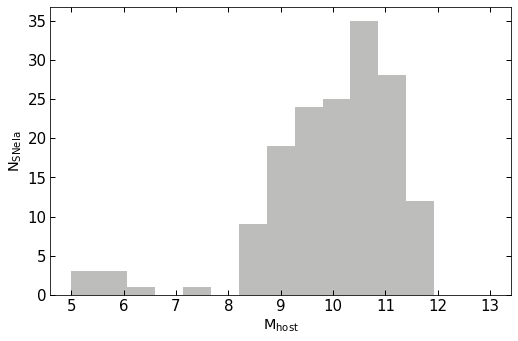

In [32]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(df[df['survey'] == su.value].hostmass,
        range=[5, 13],
        bins=15,
        color=colors[su.value],
        alpha = .5, histtype='stepfilled', lw=2)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{M}_\mathrm{host}$", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$ ", fontsize="x-large")

In [6]:
def gauss(M, mu, sigma, normed=True):
    '''Le modèle de distribution'''
    sigma_eff = np.sqrt(sigma**2)
    norm = 1 if normed else np.sqrt(2*np.pi)*sigma_eff
    return norm*scipy.stats.norm.pdf(M, mu, scale=sigma_eff)

def likelihood_asym(M, mu, sigma_m, sigma_p):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    flag_up = M >= mu
    likelihood = np.zeros(len(M))
    likelihood[flag_up] = gauss(M[flag_up],
                                mu, sigma_p, normed=False)
    likelihood[~flag_up] = gauss(M[~flag_up],
                                 mu, sigma_m, normed=False)
    norm = np.sqrt(2*np.pi)*(0.5*np.sqrt(sigma_m**2)
                             + 0.5*np.sqrt(sigma_p**2))
    return likelihood/norm

def loglikelihood_asym(mu, sigma_m, sigma_p):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asym(df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                            mu,
                                            sigma_m, sigma_p)))

def minimize_asym(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asym,
                      print_level=print_level,
                      pedantic=False,
                      mu=10, sigma_m=2, sigma_p=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asym = minimize_asym().values

In [13]:
df_nHST[df_nHST['hostmass'] > 7].hostmass

0       9.566476
1      10.272276
2      10.434992
3       8.741923
4       7.925805
         ...    
388     9.589000
389     9.554000
390     9.550000
391    10.590000
392     9.107000
Name: hostmass, Length: 383, dtype: float64

In [9]:
def likelihood_gauss(M, mu_2, sigma_2):
    '''La fonction décrivant le modèle des SNe vieilles'''
    return gauss(M, mu_2, sigma_2)
                                                                            
def likelihood_asymgauss(a, M, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction prenant en compte la probabilité d'être vieille/jeune'''
    return a*likelihood_asym(M, mu, sigma_m, sigma_p) + \
        (1-a)*likelihood_gauss(M, mu_2, sigma_2)
                                                                            
def loglikelihood_asymgauss(a, mu, sigma_m, sigma_p, mu_2, sigma_2):
    '''La fonction à minimiser'''
    return -2*np.sum(np.log(likelihood_asymgauss(a,
                                                 df_nHST[df_nHST['hostmass'] > 7].hostmass,
                                                 mu, sigma_m, sigma_p,
                                                 mu_2, sigma_2)))

def minimize_asymgauss(print_level=0, **kwargs):
    '''Renvoie la meilleure valeur des paramètres'''
    m_tot = im.Minuit(loglikelihood_asymgauss,
                      print_level=print_level,
                      pedantic=False,
                      a=0.5,
                      mu=8, sigma_m=1, sigma_p=0.5,
                      mu_2=11, sigma_2=1,
                      **kwargs)
    migrad_out = m_tot.migrad()
    return(m_tot)

bestfit_asymgauss = minimize_asymgauss().values

In [10]:
bestfit_asymgauss

<ValueView of Minuit at 55ee0e4ebd20>
  a: 0.49609354921325
  mu: 9.395368741559103
  sigma_m: 0.6854991620436625
  sigma_p: 0.6630480233533436
  mu_2: 10.696920718796237
  sigma_2: 0.44123390333433177

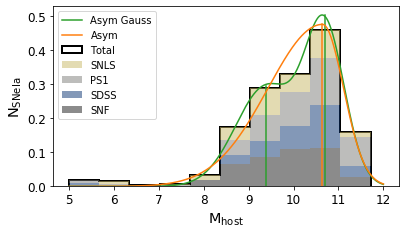

In [32]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])

alpha1colors = dict()
for survey in surveys:
    alpha1colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .1)

alpha3colors = dict()
for survey in surveys:
    alpha3colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .3)
    
alpha5colors = dict()
for survey in surveys:
    alpha5colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .5)
    
alpha8colors = dict()
for survey in surveys:
    alpha8colors[survey] = (colors[survey][0], colors[survey][1], colors[survey][2], .8)
    
stacked_bt = [df_nHST[df_nHST['survey'] == survey].hostmass for survey in surveys[:-1]]
hstclrs_bt = [list(alpha5colors.values())[i] for i in range(len(surveys[:-1]))]

ax.hist(df_nHST.hostmass,
        density=True,
        bins=10,
        histtype='step',
        lw=2, color='k',
        label='Total')

_, rang, _ = ax.hist(stacked_bt,
                     density=True,
                     stacked=True,
                     bins=10,
                     histtype='stepfilled',
                     color=hstclrs_bt,
                     label=surveys)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'$\mathrm{M}_\mathrm{host}$', fontsize = 'x-large')
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)

M_lin = np.linspace(rang[0], 12, 3000)

pdf_asymgauss = likelihood_asymgauss(bestfit_asymgauss['a'],
                                     M_lin,
                                     bestfit_asymgauss['mu'],
                                     bestfit_asymgauss['sigma_m'],
                                     bestfit_asymgauss['sigma_p'],
                                     bestfit_asymgauss['mu_2'],
                                     bestfit_asymgauss['sigma_2'])
ax.plot(M_lin, pdf_asymgauss,
        color='C2', label='Asym Gauss')

ax.vline(bestfit_asymgauss['mu'],
         color='C2',
         ymin=0, ymax=bestfit_asymgauss['a']*\
                      np.max(likelihood_asym(M_lin,
                                             bestfit_asymgauss['mu'],
                                             bestfit_asymgauss['sigma_m'],
                                             bestfit_asymgauss['sigma_p'])))

ax.vline(bestfit_asymgauss['mu_2'],
         color='C2',
         ymin=0, ymax=np.max(pdf_asymgauss))

pdf_asym = likelihood_asym(M_lin,
                           bestfit_asym['mu'],
                           bestfit_asym['sigma_m'],
                           bestfit_asym['sigma_p'])

ax.plot(M_lin, pdf_asym,
        color='C1', label='Asym')
ax.vline(bestfit_asym['mu'],
         color='C1',
         ymin=0, ymax=np.max(pdf_asym))

ax.legend(loc='upper left', fontsize='medium', ncol=1)

path = '../../Images/'
name = 'mass-cut_hist_stac-fit'
pathpdf = path + 'pdf/' + name + '.pdf'
pathpng = path + 'png/' + name + '.png'
fig.savefig(pathpdf, bbox_inches='tight')
fig.savefig(pathpng, bbox_inches='tight', dpi=600)

In [17]:
ax.get_ylim()

(-1.669842797222759, 2.168303333707165)

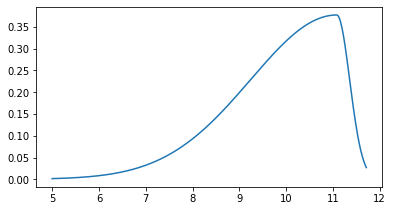

In [85]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.6, 0.5])
M_lin = np.linspace(rang[0], rang[-1], 3000)

ax.plot(M_lin, likelihood_tot(M_lin,
                              bestfit['mu'],
                              bestfit['sigma_m'],
                              bestfit['sigma_p']))

In [2]:
pdmodel = survey.PrompDelayModel()

In [3]:
pdmodel.get_distpdf_stretch([0.2, 0.4], 0.5)

array([0.48197451, 0.49583471])